In [2]:
import cv2
import numpy as np
import os
from os.path import isfile,join


Načti video a rozděl ho na snímky. 

Zdroj: https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481




In [109]:
path_to_video = '/content/drive/My Drive/MVI/videoTest/ger_flag_test_video_03.mp4'
dir_to_save_frames = "/content/drive/My Drive/MVI/videoTest/images/"

In [103]:
vidcap = cv2.VideoCapture(path_to_video)

In [104]:
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(dir_to_save_frames + "image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.2 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

Detekování vlajek pomocí YOLOv3. 

Zdroj: https://github.com/experiencor/keras-yolo3


In [107]:
import sys
sys.path.append('/content/drive/My Drive/MVI/keras-yolo3-master/') #cesta k implementaci 

In [108]:
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
from PIL import Image

In [110]:
def yolo_predict(args):
    #config_path  = args.conf
    #input_path   = args.input
    #output_path  = args.output

    config_path  = args[0]
    input_path   = args[1]
    output_path  = args[2]

    with open(config_path) as config_buffer:    
        config = json.load(config_buffer)

    makedirs(output_path)

    ###############################
    #   Set some parameter
    ###############################       
    net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
    obj_thresh, nms_thresh = 0.7, 0.3
    iou_threshold=0.7

    ###############################
    #   Load the model
    ###############################
    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    infer_model = load_model(config['train']['saved_weights_name'])

    ###############################
    #   Predict bounding boxes 
    ###############################
# do detection on an image or a set of images
    image_paths = []



    if os.path.isdir(input_path): 
        cnt = 0
        for inp_file in os.listdir(input_path):
            if(inp_file[0:5] == 'image'):
              cnt = cnt + 1
              #image_paths += [input_path + inp_file]
              #print(inp_file)
        print(cnt)
        for i in range(1,cnt+1):
          image_paths += [input_path + "image" + str(i) + ".jpg"]
          
    else:
        image_paths += [input_path]

    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

    # the main loop
    boxes_all = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        print(image_path)

        # predict the bounding boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]
        boxes_all.append(boxes)
        # draw bounding boxes on the image using labels
        draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 

        # write the image with bounding boxes to file
        cv2.imwrite(output_path + "det_" + image_path.split('/')[-1], np.uint8(image))   
        #print(output_path + "det_" + image_path.split('/')[-1])      

    return boxes_all

In [111]:
args = []
args.append('/content/drive/My Drive/MVI/keras-yolo3-master/config.json')
args.append('/content/drive/My Drive/MVI/videoTest/images/')
args.append('/content/drive/My Drive/MVI/videoTest/images/det/')


boxes_all = yolo_predict(args)

36
/content/drive/My Drive/MVI/videoTest/images/image1.jpg
/content/drive/My Drive/MVI/videoTest/images/image2.jpg
/content/drive/My Drive/MVI/videoTest/images/image3.jpg
/content/drive/My Drive/MVI/videoTest/images/image4.jpg
/content/drive/My Drive/MVI/videoTest/images/image5.jpg
/content/drive/My Drive/MVI/videoTest/images/image6.jpg
/content/drive/My Drive/MVI/videoTest/images/image7.jpg
/content/drive/My Drive/MVI/videoTest/images/image8.jpg
/content/drive/My Drive/MVI/videoTest/images/image9.jpg
/content/drive/My Drive/MVI/videoTest/images/image10.jpg
/content/drive/My Drive/MVI/videoTest/images/image11.jpg
/content/drive/My Drive/MVI/videoTest/images/image12.jpg
/content/drive/My Drive/MVI/videoTest/images/image13.jpg
/content/drive/My Drive/MVI/videoTest/images/image14.jpg
/content/drive/My Drive/MVI/videoTest/images/image15.jpg
/content/drive/My Drive/MVI/videoTest/images/image16.jpg
/content/drive/My Drive/MVI/videoTest/images/image17.jpg
/content/drive/My Drive/MVI/videoTest

Odstranění detekcí s pravděpodobností menší než daný threshold.

In [112]:
boxes_all_cp = boxes_all.copy()
cnt = 1
detection_probability_threshold = 0.7
boxes_all_filtered = []
for boxes_img in boxes_all_cp:
  print('img ' + str(cnt) + '--------------------------')
  cnt = cnt +1
  boxes_tmp = boxes_img.copy()
  boxes = []
  for box in boxes_tmp:
    print(box.classes[0])
    if(box.classes[0] > detection_probability_threshold):
      boxes.append(box)
  boxes_all_filtered.append(boxes)

img 1--------------------------
0.0
0.9947726
img 2--------------------------
0.0
0.9948801
img 3--------------------------
0.0
0.9948768
img 4--------------------------
0.0
0.99484766
img 5--------------------------
0.0
0.9948657
img 6--------------------------
0.0
0.9956696
0.0
img 7--------------------------
0.0
0.9959841
0.0
img 8--------------------------
0.0
0.9965912
0.0
0.75368905
img 9--------------------------
0.0
0.99692094
0.0
img 10--------------------------
0.9981351
0.0
img 11--------------------------
0.998733
0.0
img 12--------------------------
0.99782914
0.0
img 13--------------------------
0.9979
0.0
img 14--------------------------
0.99795306
0.0
img 15--------------------------
0.99790895
0.0
img 16--------------------------
0.9980106
0.0
img 17--------------------------
0.9986254
0.0
img 18--------------------------
0.9992305
0.0
img 19--------------------------
0.9994692
img 20--------------------------
img 21--------------------------
0.9940691
img 22----------

Výřez bounding box detekovaných vlajek pomocí YOLOv3.

image 1
(195, 97)


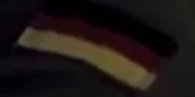

image 2
(195, 97)


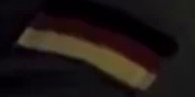

image 3
(195, 97)


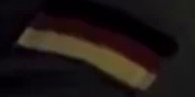

image 4
(195, 98)


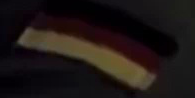

image 5
(195, 98)


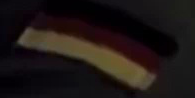

image 6
(208, 103)


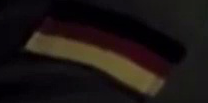

image 7
(210, 103)


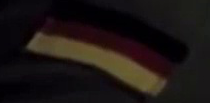

image 8
(208, 102)


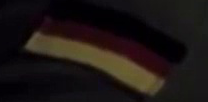

(77, 67)


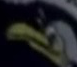

image 9
(209, 102)


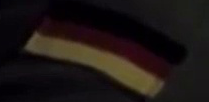

image 10
(215, 102)


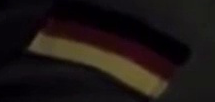

image 11
(220, 101)


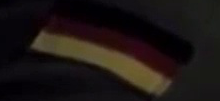

image 12
(226, 100)


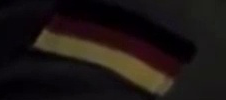

image 13
(227, 99)


image 14
(226, 99)


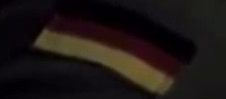

image 15
(226, 99)


image 16
(225, 99)


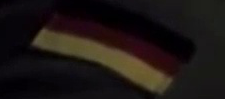

image 17
(224, 101)


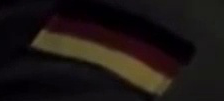

image 18
(213, 103)


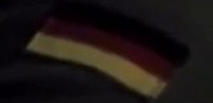

image 19
(213, 107)


image 20
image 21
(44, 49)


image 22
(42, 52)


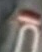

image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
(117, 83)


(137, 76)


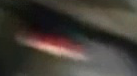

image 31
image 32
(259, 89)


image 33
(66, 50)


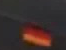

image 34
(73, 66)


image 35
(73, 64)


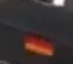

image 36
(72, 63)


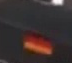

In [113]:
cnt_image = 1
cropped_images_lst = []
cropped_images_top_left_coordinate_lst = []
cropped_images_sizes_lst = []
cnt = 1


for boxes_in_image in boxes_all_filtered:
  print("image " + str(cnt_image))
  cropped_images = []
  cropped_images_top_left_coordinate = []
  cropped_images_sizes = []
  for box in boxes_in_image:
    im = Image.open('/content/drive/My Drive/MVI/videoTest/images/image' + str(cnt_image) + '.jpg')
    area = (box.xmin, box.ymin, box.xmax, box.ymax)
    cropped_img = im.crop(area)
    cropped_images.append(cropped_img)
    cropped_images_top_left_coordinate.append((box.xmin, box.ymin))
    cropped_images_sizes.append(cropped_img.size)
    print(cropped_img.size)
    display(cropped_img)
    cropped_img.save("/content/drive/My Drive/MVI/videoTest/images/croppedImages/img"+str(cnt)+ ".jpg")
    cnt = cnt + 1
  cropped_images_lst.append(cropped_images)
  cropped_images_top_left_coordinate_lst.append(cropped_images_top_left_coordinate)
  cropped_images_sizes_lst.append(cropped_images_sizes)
  cnt_image = cnt_image + 1

Aplikace Cycle-GAN na výřezy vlajek.

Zdroj: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

In [11]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_hz0nn22
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_hz0nn22
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=fab9e07d2ea08f7fdcbe186b1ec107d6c4bc46208ff1f23c5bf86d5364bc34bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_nx7s1l/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [12]:
sys.path.append('/content/drive/My Drive/MVI/GAN/')
sys.path.append('/content/drive/My Drive/MVI/GAN/gan.py') #implemetace cycleGAN

In [13]:
from gan import define_generator
from gan import define_discriminator
from gan import define_composite_model

In [14]:
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

d_model_A.load_weights("/content/drive/My Drive/MVI/d_model_A.h5")
d_model_B.load_weights("/content/drive/My Drive/MVI/d_model_B.h5")

g_model_AtoB.load_weights("/content/drive/My Drive/MVI/g_model_AtoB.h5")
g_model_BtoA.load_weights("/content/drive/My Drive/MVI/g_model_BtoA.h5")

c_model_AtoB.load_weights("/content/drive/My Drive/MVI/c_model_AtoB.h5")
c_model_BtoA.load_weights("/content/drive/My Drive/MVI/c_model_BtoA.h5")

In [47]:
import glob
from PIL import Image
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model

import tensorflow as tf

import random
import numpy as np

In [26]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    #img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

Převod vyříznutých nášivek na tensor.

In [114]:

orig_img_size = (256, 256)

#tf.config.run_functions_eagerly(True)

image_list = []
for img_lst in cropped_images_lst: 
    if len(img_lst) != 0:
      for im in img_lst:
        #im = tf.keras.preprocessing.image.load_img(im, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest" )
        im = tf.keras.preprocessing.image.img_to_array(im, data_format=None, dtype=None)
        im = preprocess_train_image(im)
        im = im.numpy()
        image_list.append(im)
image_list = np.array(image_list)



Aplikace cycle-GAN

In [115]:
#usa to ger
#pred_crop = g_model_AtoB.predict(image_list)

#ger to usa
pred_crop = g_model_BtoA.predict(image_list)

Prevod z tensoru do RGB obrázku

In [116]:

pred_crop_PIL_format_lst = []

#for i in range(0,len(pred_crop)):
#  norm_image = cv2.normalize(pred_crop[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#  nm = norm_image.astype(np.uint8)
#  image = Image.fromarray(nm, "RGB")
#  newsize = (cropped_images_sizes_lst[i][0], cropped_images_sizes_lst[i][1]) 
#  image = image.resize(newsize) 
#  pred_crop_PIL_format.append(image)

pred_crop_PIL_format = []
cnt_image = 0
cnt_pred = 0
for flags_lst in cropped_images_lst: 
    if len(flags_lst) != 0:
      cnt_flag_in_image = 0
      print("img " + str(cnt_image) + " flags " + str(len(flags_lst)))
      pred_crop_PIL_format = []
      for im in flags_lst:
        norm_image = cv2.normalize(pred_crop[cnt_pred], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        cnt_pred = cnt_pred + 1
        nm = norm_image.astype(np.uint8)
        image = Image.fromarray(nm, "RGB")
        print(str(cnt_image) + ", " + str(cnt_flag_in_image))
        newsize = (cropped_images_sizes_lst[cnt_image][cnt_flag_in_image][0], cropped_images_sizes_lst[cnt_image][cnt_flag_in_image][1]) 
        image = image.resize(newsize) 
        pred_crop_PIL_format.append(image)
        cnt_flag_in_image = cnt_flag_in_image + 1
    pred_crop_PIL_format_lst.append(pred_crop_PIL_format)
    cnt_image = cnt_image + 1




img 0 flags 1
0, 0
img 1 flags 1
1, 0
img 2 flags 1
2, 0
img 3 flags 1
3, 0
img 4 flags 1
4, 0
img 5 flags 1
5, 0
img 6 flags 1
6, 0
img 7 flags 2
7, 0
7, 1
img 8 flags 1
8, 0
img 9 flags 1
9, 0
img 10 flags 1
10, 0
img 11 flags 1
11, 0
img 12 flags 1
12, 0
img 13 flags 1
13, 0
img 14 flags 1
14, 0
img 15 flags 1
15, 0
img 16 flags 1
16, 0
img 17 flags 1
17, 0
img 18 flags 1
18, 0
img 20 flags 1
20, 0
img 21 flags 1
21, 0
img 29 flags 2
29, 0
29, 1
img 31 flags 1
31, 0
img 32 flags 1
32, 0
img 33 flags 1
33, 0
img 34 flags 1
34, 0
img 35 flags 1
35, 0


Nahrání snímků videa do pole.

In [117]:
data_dir_images = '/content/drive/My Drive/MVI/videoTest/images/'
images_orig_arr = []
cnt = 0
for inp_file in os.listdir(data_dir_images):
  #print(inp_file)
  if(inp_file[0:5] == 'image'):
    cnt = cnt + 1
    #image_paths += [input_path + inp_file]
    #print(inp_file)
print(cnt)
for i in range(1,cnt+1):
  #image_paths += [input_path + "img" + str(i) + ".jpg"]
  path = data_dir_images + "image" + str(i) + ".jpg"
  print(path)
  images_orig_arr.append(Image.open(path))

36
/content/drive/My Drive/MVI/videoTest/images/image1.jpg
/content/drive/My Drive/MVI/videoTest/images/image2.jpg
/content/drive/My Drive/MVI/videoTest/images/image3.jpg
/content/drive/My Drive/MVI/videoTest/images/image4.jpg
/content/drive/My Drive/MVI/videoTest/images/image5.jpg
/content/drive/My Drive/MVI/videoTest/images/image6.jpg
/content/drive/My Drive/MVI/videoTest/images/image7.jpg
/content/drive/My Drive/MVI/videoTest/images/image8.jpg
/content/drive/My Drive/MVI/videoTest/images/image9.jpg
/content/drive/My Drive/MVI/videoTest/images/image10.jpg
/content/drive/My Drive/MVI/videoTest/images/image11.jpg
/content/drive/My Drive/MVI/videoTest/images/image12.jpg
/content/drive/My Drive/MVI/videoTest/images/image13.jpg
/content/drive/My Drive/MVI/videoTest/images/image14.jpg
/content/drive/My Drive/MVI/videoTest/images/image15.jpg
/content/drive/My Drive/MVI/videoTest/images/image16.jpg
/content/drive/My Drive/MVI/videoTest/images/image17.jpg
/content/drive/My Drive/MVI/videoTest

Zde by mělo dojít k nalezení masek nášivek, v jiném notebooku, neboť vyžaduje jinou verzi tensorflow nekompatibilní s těmi, které chtejí ostatní modely.

Nahraní masek z mask R-CNN

In [118]:
data_dir_images = '/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/'
pred_crop_masks = []
cnt = 0
for inp_file in os.listdir(data_dir_images):
  #print(inp_file)
  if(inp_file[0:4] == 'mask'):
    cnt = cnt + 1
    #image_paths += [input_path + inp_file]
    #print(inp_file)
print(cnt)
for i in range(1,cnt+1):
  #image_paths += [input_path + "img" + str(i) + ".jpg"]
  path = data_dir_images + "mask" + str(i) + ".jpg"
  print(path)
  pred_crop_masks.append(Image.open(path))




29
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask1.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask2.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask3.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask4.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask5.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask6.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask7.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask8.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask9.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask10.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask11.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask12.jpg
/content/drive/My Drive/MVI/videoTest/images/croppedImagesMasks/mask13.jpg
/content/drive/My Drive/MVI/vid

Umístění transformace z cycle-GAN pomocí masky z mask-RCNN na výřez z YOLOv3

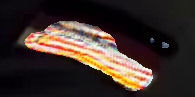

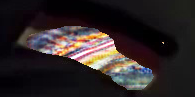

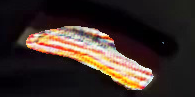

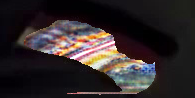

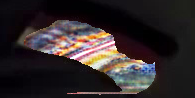

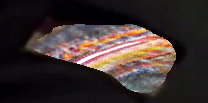

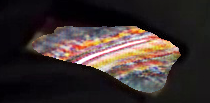

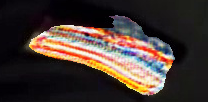

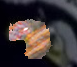

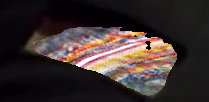

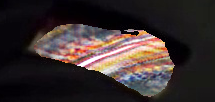

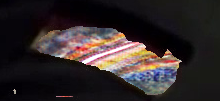

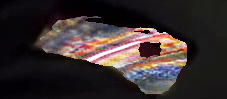

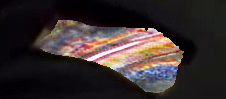

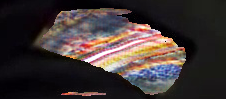

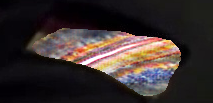

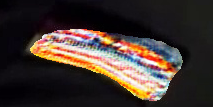

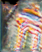

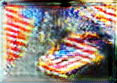

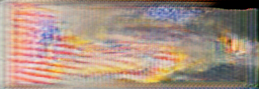

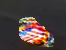

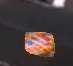

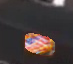

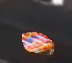

In [119]:
cnt_image = 0 
cnt_mask = 0
pred_crop_PIL_format_composite_lst = []
pred_crop_PIL_format_composite = []
for flags_lst in cropped_images_lst: 
    if len(flags_lst) != 0:
      cnt_flag_in_image = 0
      pred_crop_PIL_format_composite = []
      for im in flags_lst:
        composite_image = Image.composite(pred_crop_PIL_format_lst[cnt_image][cnt_flag_in_image],cropped_images_lst[cnt_image][cnt_flag_in_image],pred_crop_masks[cnt_mask])
        display(composite_image)
        pred_crop_PIL_format_composite.append(composite_image)
        cnt_mask = cnt_mask + 1
        cnt_flag_in_image = cnt_flag_in_image + 1
    pred_crop_PIL_format_composite_lst.append(pred_crop_PIL_format_composite)
    cnt_image = cnt_image + 1

Umístění transformace na původní obrázek.

In [120]:
cnt_image = 0 
cnt_frame = 0
for flags_lst in cropped_images_lst: 
    if len(flags_lst) != 0:
      cnt_flag_in_image = 0
      for im in flags_lst:
        print(str(cnt_image) + ", " + str(cnt_flag_in_image) + "," + str(cnt_frame))
        topLeft = cropped_images_top_left_coordinate_lst[cnt_image][cnt_flag_in_image]
        
        images_orig_arr[cnt_frame].paste(pred_crop_PIL_format_composite_lst[cnt_image][cnt_flag_in_image],topLeft)
        cnt_flag_in_image = cnt_flag_in_image + 1
    cnt_frame = cnt_frame + 1
    cnt_image = cnt_image + 1



0, 0,0
1, 0,1
2, 0,2
3, 0,3
4, 0,4
5, 0,5
6, 0,6
7, 0,7
7, 1,7
8, 0,8
9, 0,9
10, 0,10
11, 0,11
12, 0,12
13, 0,13
14, 0,14
15, 0,15
16, 0,16
17, 0,17
18, 0,18
20, 0,20
21, 0,21
29, 0,29
29, 1,29
31, 0,31
32, 0,32
33, 0,33
34, 0,34
35, 0,35


Složení transformovaných snímků do videa.

In [121]:
pathOut = '/content/drive/My Drive/MVI/videoTest/result_ger_flag_test_video_03.mp4'


fps = 1/frameRate

frame_array = []

for i in range(len(images_orig_arr)):
    open_cv_image = cv2.cvtColor(np.array(images_orig_arr[i]), cv2.COLOR_RGB2BGR)
    size = images_orig_arr[i].size
    
    #inserting the frames into an image array
    frame_array.append(open_cv_image)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()